![Caption](images/Q06.png)

#### Explain deformable models for image segmentation:

1. The task is to perform image segmentation on an image. In particular we look at using the Chan-Vese algorithm to track a deformation in a series of images.
2. The basic idea of deformable models is to evolve a curve in an image and thus perform the segmentation. We control the curve using external and internal energies. External stems from the image, and internal stems from the curve itself.
3. There exists mainly two classes of deformable models, namely parametric and implicit. In parametric models we model explicitly using a set of points and with implicit models we model using functions. In parametric we can update pointwise which is an advantage. Parametric has the disadvantage that it has to be continous (consider example with 60). We also have to regularize the parametric snake in order for it to behave properly.
4. We consider the Mumford-Shah functional namely: $E(J, \Gamma) = \lambda \int_{\Omega}(J-I)^2dx + \int_{\Omega \text{\\} \Gamma}|\nabla I|^2dx + \mu \int_{\Gamma}ds$. We consider the piecewise-constant case for the sake of Chan-Vese from which we then have $E(J, \Gamma) = \lambda \int_{\Omega}(J-I)^2dx + \mu \int_{\Gamma}ds$.

5. In Chan-Vese we consider the piecewise-constant Mumford-Shah functional where the first integral $\lambda \int_{\Omega}(J-I)^2dx$ is the external energy and $\mu \int_{\Gamma}ds$ is the energy originating from the snake itself.

6. The external energy we then model as $E_{ext}=\int_{\Omega_{in}}(I-m_{in})^2dw + \int_{\Omega_{out}}(I-m_{out})^2dw$. Based on this we come up with an evolution $F_{ext} = (m_{in}-m_{out})(2I-m_{in}-m_{out})N$ which will deform our curve towards the minimum for a specific point (where $N$ is the unit normal vector to the curve).

7. The internal energy of the curve is dependent on the elasiticity and rigidity of the curve. We express the internal energy as $E_{in} = \frac{1}{2} \int \alpha |\frac{\partial C}{\partial s}|^2 + \beta |\frac{\partial^2 C}{\partial s^2}|^2 ds$ ( first partial is elasticity, second partial is rigidness).  The internal energy is essentially a regularizer on our curve. This leads to the internal force $F_{int} = \frac{\partial}{\partial s}(\alpha \frac{\partial C}{\partial s}) + \frac{\partial^2}{\partial s^2}(\beta \frac{\partial^2 C}{\partial s^2})^2$. Practically speaking we do this using two filters, $\alpha$ [1 -2 1] and $\beta$[-1 4 -6 4 -1].

8. The update step in a discrete setting such as ours now becomes: $\mathbf{C}^t = \mathbf{B}_{int}(\mathbf{C}^{t-1}+\tau \text{diag}(\mathbf{F}_{ext})\mathbf{N}^{t-1})$.

9. The algorithm consists of:
    * Initalize curve.
    * Compute $m_{in}$ and $m_{out}$.
    * Compute $F_{ext}$ and evolve curve based on this (with smaller stepsize).
    * Smooth curve.
    * Fix curve.

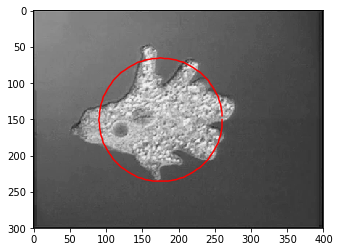

In [22]:
import imageio
from imageio import get_reader
import numpy as np
import math
import matplotlib.pyplot as plt
import skimage.draw as draw
mov = get_reader("week_6/data/crawling_amoeba.mov")
# parameters
n=100
frames = np.zeros((478, 300, 400))
snake = np.zeros((n, 2))
x_0 = 175
y_0 = 150
r = 85
angle = 1/(n)
alpha = 1
beta = 1
# fill frames with grayscale frames
for i, frame in enumerate(mov):
    frames[i,:,:]=frame[:,:,0]/255.
    
# fill the snake for initialization:
for i, coord in enumerate(snake):
    coord = [x_0 + np.ceil(r*math.cos(2*i*math.pi*angle)), y_0 + np.ceil(r*math.sin(2*i*math.pi*angle))]
    snake[i] = coord
#snake[-1,:] = snake[0,:] #ensures closed curve

plt.plot(snake[:,0], snake[:,1], color = 'red')
plt.imshow(frames[0], cmap="gray")
plt.show()

In [23]:
mask = draw.polygon2mask(frames[0].shape, snake)

def m1m2(frame, snake, mask):
    c_in, c_out=0, 0
    m_in, m_out=0, 0
    x, y=frame.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j]:
                m_in=((c_in)/(c_in+1))*m_in + 1/(c_in+1)*frame[i,j]
                c_in+=1
            else:
                m_out=((c_out)/(c_out+1))*m_out + 1/(c_out+1)*frame[i,j]
                c_out+=1
    return m_in, m_out, c_in, c_out

m_in, m_out, c_in, c_out = m1m2(frames[0], snake, mask)
print(m_in, m_out)
def forceImage_ext(frame, snake, m_in, m_out):
    z = np.array(list(map(lambda x: frame[int(x[0]), int(x[1])], snake)))
    f_ext = (m_in-m_out)*(z-0.5*(m_in+m_out))
    return f_ext
z = forceImage_ext(frames[0], snake, m_in, m_out)
def snakeNormals(snake):
    N = np.zeros((len(snake), 2))
    diff = snake[1,:]-snake[-1,:]
    N[0,:] = [diff[1], -diff[0]]
    for i in range(len(snake)-2):
        k=i+1
        diff = snake[k+1,:]-snake[k-1]
        N[k,:] = [diff[1], -diff[0]]
    diff = snake[0,:]-snake[-2,:]
    N[-1,:] = [diff[1], -diff[0]]
    return N
N = snakeNormals(snake)

0.5503292801219387 0.3462047867626851


## Visualisation of displacement

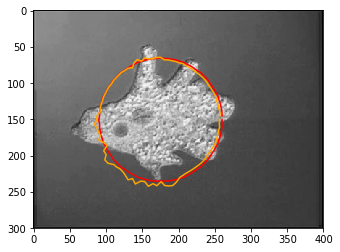

In [24]:
displacement = 10*np.array([N[i]*z[i] for i in range(100)])
plt.plot(snake[:,0], snake[:,1], color = 'red')
plt.plot(snake[:,0]+displacement[:,0], snake[:,1]+displacement[:,1], color = 'orange')
plt.imshow(frames[0], cmap="gray")
plt.show()
def extendedKernelSmothing(alpha, beta, N):
    Alph = np.zeros((N,N))
    Alph[1:, :-1] = Alph[1:, :-1] + np.identity(N-1)
    Alph[:-1, 1:] = Alph[:-1, 1:] + np.identity(N-1)
    Alph = Alph + (-2)*np.identity(N)
    Alph[0,N-1] = 1
    Alph[N-1,0] = 1
    Bet = np.zeros((N,N)) + (-6)*np.identity(N)
    Bet[2:,:-2] = Bet[2:,:-2] + (-1)*np.identity(N-2)
    Bet[:-2,2:] = Bet[:-2,2:] + (-1)*np.identity(N-2)
    Bet[1:,:-1] = Bet[1:,:-1] + 4*np.identity(N-1)
    Bet[:-1,1:] = Bet[:-1,1:] + 4*np.identity(N-1)
    Bet[0,N-2] = -1
    Bet[1,N-1] = -1
    Bet[N-2,0] = -1
    Bet[N-1,1] = -1
    Bet[N-1, 0] = 4
    Bet[0, N-1] = 4
    #print(Alph)
    #print(Bet)
    return(alpha*Alph + beta*Bet)

B_int = extendedKernelSmothing(alpha, beta, n)
snake_smooth = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake) # smooth snake as in the week 1 exercise.

## Run the displacement in a loop for initialisation:

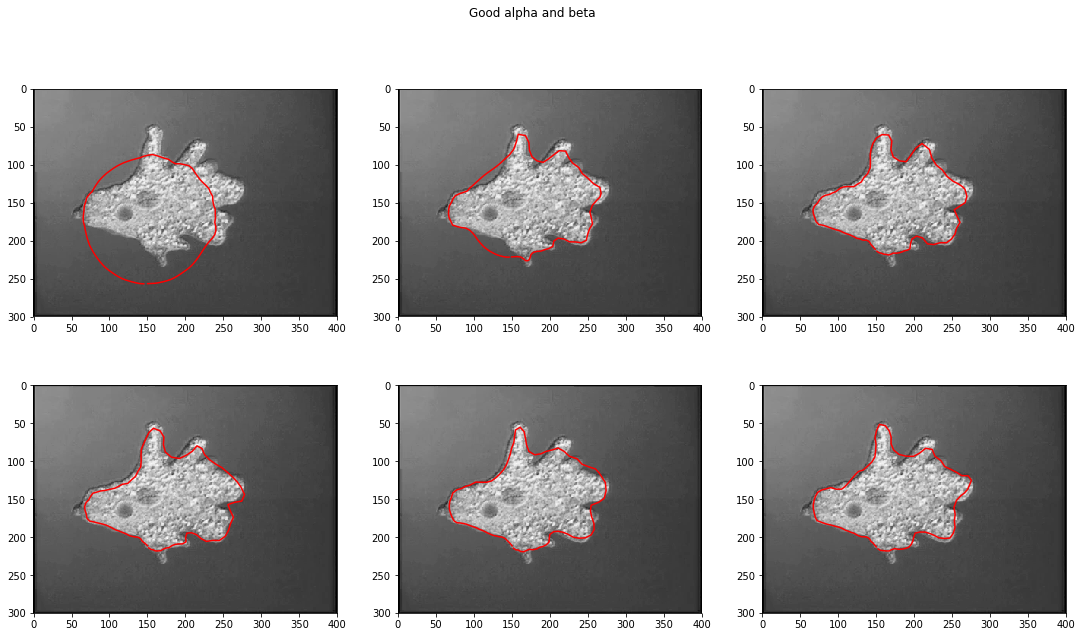

In [25]:
# parameters with good beta and alpha
n=100
frames = np.zeros((478, 300, 400))
snake = np.zeros((n, 2))
x_0 = 175
y_0 = 150
r = 85
angle = 1/(n)
alpha = 1
beta = 0.1
B_int = extendedKernelSmothing(alpha, beta, n)

# fill frames with grayscale frames
for i, frame in enumerate(mov):
    frames[i,:,:]=frame[:,:,0]/255.
    
# fill the snake for initialization:
for i, coord in enumerate(snake):
    coord = [x_0 + np.ceil(r*math.cos(2*i*math.pi*angle)), y_0 + np.ceil(r*math.sin(2*i*math.pi*angle))]
    snake[i] = coord
#snake[-1,:] = snake[0,:] #ensures closed curve
# Find intialization of snake
%matplotlib inline
def updateSnake(snake, frame):
    mask = draw.polygon2mask(frame.shape, snake) # get inside/outside
    m_in, m_out, c_in, c_out = m1m2(frame, snake, mask) # get averages inside/outside
    z = forceImage_ext(frame, snake, m_in, m_out) # get values of force on curve
    N = snakeNormals(snake)
    
    displacement = 10*np.array([N[i]*z[i] for i in range(n)])
    snake_smooth = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake + displacement)
    return snake_smooth

fig, axs = plt.subplots(2, 3)
# Intitialize snake:
for i in range(60):
    snake = updateSnake(snake, frames[0])
    if i==0:
        axs[0,0].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs[0,0].imshow(frames[0], cmap="gray")
    elif i==9:
        axs[0,1].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs[0,1].imshow(frames[0], cmap="gray")
    elif i==19:
        axs[0,2].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs[0,2].imshow(frames[0], cmap="gray")
    elif i==29:
        axs[1,0].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs[1,0].imshow(frames[0], cmap="gray")
    elif i==39:
        axs[1,1].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs[1,1].imshow(frames[0], cmap="gray")
    elif i==49:
        axs[1,2].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs[1,2].imshow(frames[0], cmap="gray")
fig.set_size_inches(18.5,10)
fig.suptitle("Good alpha and beta")
fig.show()

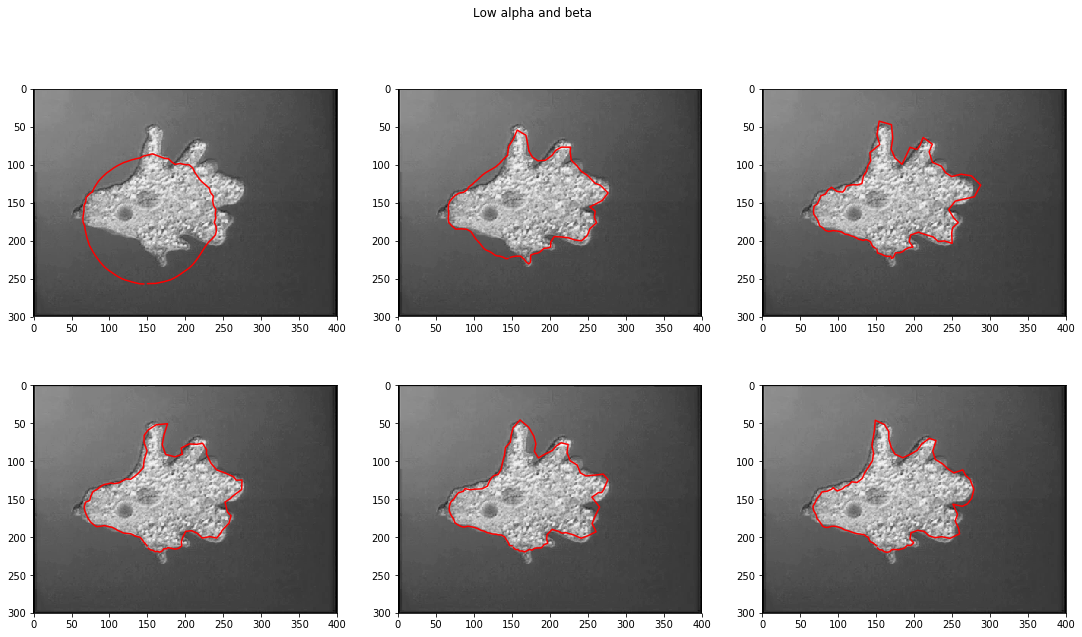

In [26]:
# parameters with low beta and alpha
n=100
frames = np.zeros((478, 300, 400))
snake = np.zeros((n, 2))
x_0 = 175
y_0 = 150
r = 85
angle = 1/(n)
alpha = 0.5
beta = 0
B_int = extendedKernelSmothing(alpha, beta, n)

# fill frames with grayscale frames
for i, frame in enumerate(mov):
    frames[i,:,:]=frame[:,:,0]/255.
    
# fill the snake for initialization:
for i, coord in enumerate(snake):
    coord = [x_0 + np.ceil(r*math.cos(2*i*math.pi*angle)), y_0 + np.ceil(r*math.sin(2*i*math.pi*angle))]
    snake[i] = coord
#snake[-1,:] = snake[0,:] #ensures closed curve
# Find intialization of snake
%matplotlib inline
def updateSnake(snake, frame):
    mask = draw.polygon2mask(frame.shape, snake) # get inside/outside
    m_in, m_out, c_in, c_out = m1m2(frame, snake, mask) # get averages inside/outside
    z = forceImage_ext(frame, snake, m_in, m_out) # get values of force on curve
    N = snakeNormals(snake)
    
    displacement = 10*np.array([N[i]*z[i] for i in range(n)])
    snake_smooth = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake + displacement)
    return snake_smooth

fig1, axs1 = plt.subplots(2, 3)
# Intitialize snake:
for i in range(60):
    snake = updateSnake(snake, frames[0])
    if i==0:
        axs1[0,0].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[0,0].imshow(frames[0], cmap="gray")
    elif i==9:
        axs1[0,1].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[0,1].imshow(frames[0], cmap="gray")
    elif i==19:
        axs1[0,2].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[0,2].imshow(frames[0], cmap="gray")
    elif i==29:
        axs1[1,0].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[1,0].imshow(frames[0], cmap="gray")
    elif i==39:
        axs1[1,1].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[1,1].imshow(frames[0], cmap="gray")
    elif i==49:
        axs1[1,2].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[1,2].imshow(frames[0], cmap="gray")
fig1.set_size_inches(18.5,10)
fig1.suptitle("Low alpha and beta")
fig1.show()

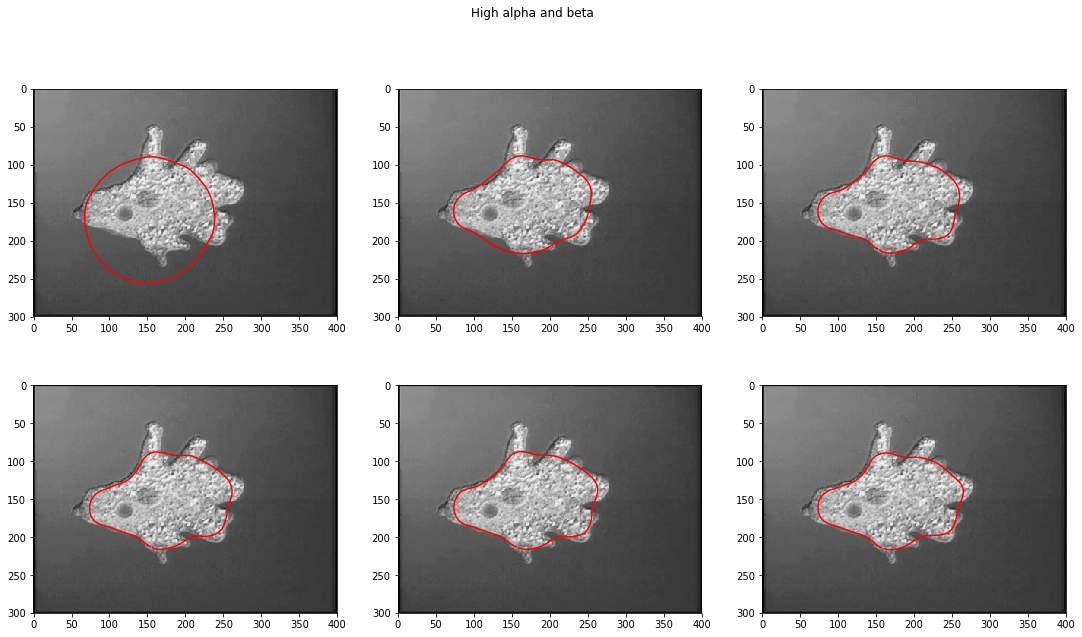

In [27]:
# parameters
n=100
frames = np.zeros((478, 300, 400))
snake = np.zeros((n, 2))
x_0 = 175
y_0 = 150
r = 85
angle = 1/(n)
alpha = 5
beta = 5
B_int = extendedKernelSmothing(alpha, beta, n)

# fill frames with grayscale frames
for i, frame in enumerate(mov):
    frames[i,:,:]=frame[:,:,0]/255.
    
# fill the snake for initialization:
for i, coord in enumerate(snake):
    coord = [x_0 + np.ceil(r*math.cos(2*i*math.pi*angle)), y_0 + np.ceil(r*math.sin(2*i*math.pi*angle))]
    snake[i] = coord
#snake[-1,:] = snake[0,:] #ensures closed curve
# Find intialization of snake
%matplotlib inline
def updateSnake(snake, frame):
    mask = draw.polygon2mask(frame.shape, snake) # get inside/outside
    m_in, m_out, c_in, c_out = m1m2(frame, snake, mask) # get averages inside/outside
    z = forceImage_ext(frame, snake, m_in, m_out) # get values of force on curve
    N = snakeNormals(snake)
    
    displacement = 10*np.array([N[i]*z[i] for i in range(n)])
    snake_smooth = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake + displacement)
    return snake_smooth

fig1, axs1 = plt.subplots(2, 3)
# Intitialize snake:
for i in range(60):
    snake = updateSnake(snake, frames[0])
    if i==0:
        axs1[0,0].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[0,0].imshow(frames[0], cmap="gray")
    elif i==9:
        axs1[0,1].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[0,1].imshow(frames[0], cmap="gray")
    elif i==19:
        axs1[0,2].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[0,2].imshow(frames[0], cmap="gray")
    elif i==29:
        axs1[1,0].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[1,0].imshow(frames[0], cmap="gray")
    elif i==39:
        axs1[1,1].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[1,1].imshow(frames[0], cmap="gray")
    elif i==49:
        axs1[1,2].plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        axs1[1,2].imshow(frames[0], cmap="gray")
fig1.set_size_inches(18.5,10)
fig1.suptitle("High alpha and beta")
fig1.show()